## Preprocessing of the reactions in the OPRD dataset

The goal of this notebook is to refine the Reactions downloaded from Reaxys to include only those reactions which
have complete information for reactants and products. Also removed will be reactions which have electro/photochemical and enzymatic tags. Only those reactions which have information for time, temperature and yield will be carried forwards into the next notebook.  

In [1]:
import pandas as pd
import itertools
import os
import glob
import matplotlib.pyplot as plt

In [11]:
# Function to write to a text file for keeping logs
def addToFile(file, what):
    f = open(file, 'a').write(what) 

## Remove entries with missing data

In [2]:
# Define current working directory so we can navigate folders easily
cwd = os.getcwd()
cwd

'/home/gah/oprd/jupyter'

In [5]:
# Change directory to the directory above the working directory
os.chdir('../')

In [8]:
# Assign this file path to a variable name so we can reference to it when saving files
pwd = os.getcwd()
pwd

'/home/gah/oprd'

In [9]:
# Assign logfile path
logfile = pwd+'/logs/data_processing.txt'

In [12]:
# Read in raw data
raw_data = pd.read_excel(pwd+'/data/raw_data_master.xlsx')

# Logfile entry - total # reactions in raw dataset
addToFile(logfile,
         ('Total number of reactions to be processed: {}\n'.format(len(raw_data))))

# Drop na entries on Reaction Smiles column
raw_data.dropna(subset=['Reaction'], inplace=True)

# Remove entries that are missing reactant and product SMILES
raw_data = raw_data[~raw_data['Reaction'].str.endswith('>>')]
raw_data = raw_data[~raw_data['Reaction'].str.startswith('>>')]

# Logfile entry - total # reactions after missing entries removed
addToFile(logfile,
         ('Total number of reactions after missing reagent/product SMILES removed: {}\n'
          .format(len(raw_data))))

# Fill in missing entries on conditions column to allow for filtering
raw_data['Other Conditions'].fillna(value='None', inplace=True)
raw_data['Multi-step Details'].fillna(value='None', inplace=True)

# Filter out all unwanted reactions
key_words = ['Electrochemical', 'Electrolysis', 'Photolysis', 'Enzymatic']
mask = raw_data[raw_data['Other Conditions'].str.contains(r'\b(?:{})\b'.format('|'.join(key_words)))]
mask2 = raw_data[raw_data['Multi-step Details'].str.contains(r'\b(?:{})\b'.format('|'.join(key_words)))]

# Drop the Electro/Photolysis and electrochemical and enzymatic reactions
combined = raw_data.append(mask)
combined = combined.append(mask2)
remaining = combined[~combined.index.duplicated(keep=False)]

# Logfile entry - total # reactions after blanks and missing entries removed
addToFile(logfile,
         ('Total number of reactions after Electrochemical,\
          Electro/Photolysis and Enzymatic reactions removed: {}\n'
          .format(len(remaining))))


## Getting to the reactions which can be used

For the purpose of creating reactivity scales, we need reactions with reaction time, temperature and yield data. There are 3 possible entries for yield: Yield, Yield (numerical) and Yield (optical). With prediction of yields in mind, I want to keep the data as uniform as possible, so I will only keep those reactions which have a numerical % yield, not a mass in g, nor an optical yield. To get all the values which have yield data of some form, use .agg on the 3 yield columns to create a new column which enables us to capture all entries with yield information.

In [13]:
# Copy dataframe from above so we can do analysis on it
analysis = remaining.copy()
analysis.fillna(value='None', inplace=True)
analysis['Yield combined'] = analysis[['Yield',
                                       'Yield (numerical)',
                                       'Yield (optical)']].agg(''.join, axis=1)

In [19]:
# Function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+10, y[i], ha = 'center')

# Assign x and y        
x = ['Multi-step',
     'Single-step',
     'Multi-step\n(with yield)',
     'Single-step\n(with yield)',
     'Single-step\n(yield & time)',
     'Single-step\n(yield, time\n& temperature)']

y =  [len(analysis[analysis['Number of Reaction Steps'] !=1]),
      len(analysis[analysis['Number of Reaction Steps'] ==1]),
      len(analysis[~analysis['Number of Reaction Steps'].isin([1]) & 
                   ~analysis['Yield combined'].isin(['NoneNoneNone'])]),
      len(analysis[analysis['Number of Reaction Steps'].isin([1]) &
                   ~analysis['Yield combined'].isin(['NoneNoneNone'])]),
      len(analysis[analysis['Number of Reaction Steps'].isin([1]) &
                   ~analysis['Yield combined'].isin(['NoneNoneNone']) &
                   ~analysis['Time (Reaction Details) [h]'].isin(['None'])]),
      len(analysis[analysis['Number of Reaction Steps'].isin([1]) &
                   ~analysis['Yield combined'].isin(['NoneNoneNone']) &
                   ~analysis['Time (Reaction Details) [h]'].isin(['None']) &
                   ~analysis['Temperature (Reaction Details) [C]'].isin(['None'])])]

## Graph to show distribution of yield data between one-step and multi-step reactions

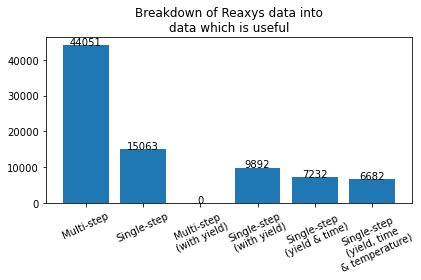

In [20]:
# Making the bar chart on the data
plt.bar(x, y)      
# Calling the function to add value labels
addlabels(x, y)
# Rotate x ticks
plt.xticks(rotation=25)
# Add a title
plt.title('Breakdown of Reaxys data into\ndata which is useful')
# Add tight layout to make the axis fit into figure box
plt.tight_layout()
# Save it as a pdf
plt.savefig(pwd+'/plots/plot_1_data_breakdown.pdf')

## Isolating the useful reactions

In [35]:
# Some yield information is given in mass (useful :D).
# The common theme with these is that they all have the unit g.
# how many are like this?
with_mass = analysis[analysis['Number of Reaction Steps'].isin([1]) &
                   ~analysis['Yield combined'].isin(['NoneNoneNone']) &
                   ~analysis['Time (Reaction Details) [h]'].isin(['None']) &
                   ~analysis['Temperature (Reaction Details) [C]'].isin(['None'])]
addToFile(logfile,
          ('Number of one step reactions (w/ t & T) with yield given in mass: {}\n'
           .format(len(with_mass[with_mass['Yield combined'].str.contains('g')]))))


# Isolate the reactions which have a % yield, disregarding the optical and mass yields
# Those reactions which have yield reported in mass or optical yield do not have an entry
# in the numerical yield column, so we don't need to further filter.
useful_reactions = analysis[analysis['Number of Reaction Steps'].isin([1]) &
                           ~analysis['Yield (numerical)'].isin(['None']) &
                           ~analysis['Time (Reaction Details) [h]'].isin(['None']) &
                           ~analysis['Temperature (Reaction Details) [C]'].isin(['None'])]

In [37]:
# Add number of reactions taken forward into next steps to logfile
addToFile(logfile,
          ('Number of one step reactions (w/ t & T) with yield given numerically: {}\n'
           .format(len(useful_reactions))))

### Plot to show breakdown of yield data

In [44]:
# Copy the resulting dataframe again
analysis_2 = with_mass.copy()

# Create x and y again
x2 = ['Single-step\n(temperature,\n& time yield)', 'Yield (text)', 'Yield (numerical)', 'Yield (optical)',
      'Yield (as mass)']
y2 = [len(analysis_2),
      len(analysis_2[analysis_2['Yield']!='None']),
      len(analysis_2[analysis_2['Yield (numerical)']!= 'None']),
      len(analysis_2[analysis_2['Yield (optical)']!= 'None']),
      len(analysis_2[analysis_2['Yield combined'].str.contains('g')])]

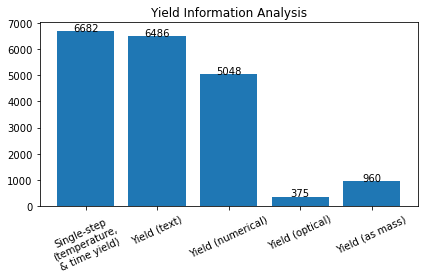

In [45]:
# Making the bar chart on the data
plt.bar(x2, y2)      
# Calling the function to add value labels
addlabels(x2, y2)
# Rotate x ticks
plt.xticks(rotation=25)
# Add a title
plt.title('Yield Information Analysis')
# Add tight layout to make the axis fir into figure box
plt.tight_layout()
# Save it as a pdf
plt.savefig(pwd+'/plots/plot_2_yield_breakdown.pdf')

In [46]:
# Saving the one step reactions with time, % yield and temperature to csv file for further use
useful_reactions.to_csv(pwd+'/data/useful_reactions.csv',index=False)